<a href="https://colab.research.google.com/github/Geebigib/Data-Science-Project/blob/main/SWaT_LSTM_unsuperivse_train%26pred.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# !pip install torchtext==0.8.0 torch==1.7.1 pytorch-lightning==1.2.2
# import pytorch_lightning as pl
# print(pl.__version__)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
from tqdm.notebook import tqdm
import pytorch_lightning as pl
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import torch
import torch.autograd as autograd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from multiprocessing import cpu_count
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import CSVLogger
from sklearn.metrics import confusion_matrix, classification_report
import scipy.stats as stats

In [5]:
%matplotlib inline
%config InlineBackend.figure_format= 'retina'

tqdm.pandas()

In [6]:
#set random seed
pl.seed_everything(44)

Global seed set to 44


44

## data preprocessing

In [7]:
# !unzip -qq SWaT_Dataset_v0.zip

In [8]:
swat_normal = pd.read_csv("SWaT_Dataset_Normal_v0.csv", skiprows=1)
swat_attack = pd.read_csv("SWaT_Dataset_Attack_v0.csv")

In [9]:
swat_normal.columns = swat_normal.columns.str.replace(' ','')
swat_attack.columns = swat_normal.columns.str.replace(' ','')

In [10]:
swat_attack["Normal/Attack"].replace(' ', '', regex=True, inplace=True)

In [11]:
swat = pd.concat([swat_normal,swat_attack],axis = 0)

le = LabelEncoder()
le.fit(swat["Normal/Attack"])

LabelEncoder()


### Process normal data
use normal data for training & tuning time window (W) and threshold (T)


In [12]:
x = swat_normal.drop(columns=["Normal/Attack","Timestamp"])
y = swat_normal.drop(np.arange(16000))["Normal/Attack"]

In [13]:
y = pd.DataFrame(
    le.transform(y), #normal 1, attack 0
    index = y.index,
    columns= ["Normal/Attack"]
)

In [14]:
# drop unsteady state operation
x.drop(np.arange(16000),inplace=True)

In [15]:
#normalise data
scaler = StandardScaler()
scaler = scaler.fit(x)

In [16]:
x_scale = pd.DataFrame(
    scaler.transform(x),
    index = x.index,
    columns= x.columns
)

In [17]:
#convert to sequence
def sequences_convert(input_data: pd.DataFrame,actual: pd.DataFrame, sequence_length):
    seqs = []
    data_size = len(input_data)
    
    for i in tqdm(range(0,data_size-sequence_length*2)):
        
        seq = input_data[i:i+sequence_length]

        label = input_data.iloc[i+sequence_length]

        # attack = actual.iloc[i+sequence_length:i+sequence_length*2]

        
        seqs.append((seq,label))
    
    return seqs



In [18]:
# # for test code
# n_test = 4000
# x_scale = x_scale[:n_test]
# y = y[:n_test]

In [19]:
# import time
sequence_length = 200
x_seq = sequences_convert(x_scale,y,sequence_length)

  0%|          | 0/480400 [00:00<?, ?it/s]

In [20]:
len(x_seq), x.shape

(480400, (480800, 51))

In [21]:
#split train/test use 80% train, 20% test (validation)
train_idx = int(len(x_seq)*0.8)
train_seq = x_seq[:train_idx]
test_seq = x_seq[train_idx:-1]


In [22]:
len(train_seq), len(test_seq)

(384320, 96079)

In [23]:
test_seq[-1]

(          FIT101    LIT101     MV101     P101  P102    AIT201    AIT202  \
 496398  0.558344 -0.677598  0.619776  0.58386   0.0 -0.392394 -0.016567   
 496399  0.547949 -0.681018  0.619776  0.58386   0.0 -0.392394 -0.016567   
 496400  0.530530 -0.677598  0.619776  0.58386   0.0 -0.392394 -0.016567   
 496401  0.524630 -0.675888  0.619776  0.58386   0.0 -0.392394 -0.016567   
 496402  0.520136 -0.680676  0.619776  0.58386   0.0 -0.392394 -0.016567   
 ...          ...       ...       ...      ...   ...       ...       ...   
 496593  0.631107 -0.665971  0.619776  0.58386   0.0 -0.392394  0.079127   
 496594  0.673810 -0.672810  0.619776  0.58386   0.0 -0.392394  0.079127   
 496595  0.710052 -0.676231  0.619776  0.58386   0.0 -0.392394  0.079127   
 496596  0.722694 -0.678624  0.619776  0.58386   0.0 -0.392394  0.079127   
 496597  0.722694 -0.675888  0.619776  0.58386   0.0 -0.392394  0.105920   
 
           AIT203    FIT201     MV201  ...    FIT504  P501  P502    PIT501  \
 496398 

In [46]:
n_features = len(x_scale.columns)

## PyTorch Dataset

In [164]:
class SWaTDataset(Dataset):
    
    def __init__(self, sequences):
        self.sequences = sequences
    
    def __len__(self):
        return len(self.sequences)
    
    def __getitem__(self,idx):
        sequences, label = self.sequences[idx]
        return dict(
        sequences = torch.Tensor(sequences.to_numpy()),
            label = torch.Tensor(label.to_numpy())
            # attack =  torch.Tensor(attack.to_numpy())
        )

In [165]:
class SWaTDataModule(pl.LightningDataModule):
    
    def __init__(self,train_seq,test_seq,batch_size):
        super().__init__()
        self.train_seq = train_seq
        self.test_seq = test_seq
        self.batch_size = batch_size
        
    def setup(self,stage = None):
        self.train_dataset = SWaTDataset(self.train_seq)
        self.test_dataset = SWaTDataset(self.test_seq)
        
    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=cpu_count()
        )
    
    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=cpu_count()
        )  
    
    def test_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=cpu_count()
        )  

In [179]:
class LSTMModel(nn.Module):
    
    def __init__(self,n_features,n_hidden=128,n_layers=3):
        super().__init__()
        
        
        self.lstm = nn.LSTM(input_size = n_features,
                            hidden_size = n_hidden,
                            num_layers = n_layers, batch_first = True, 
                            dropout = 0.75)
        
        self.classifier = nn.Linear(n_hidden, n_features)
        
    def forward(self,x):
        self.lstm.flatten_parameters()
        
        _,(hidden,_) = self.lstm(x)
        
        out = hidden[-1]
        
        out = self.classifier(out)

        # output = out.view(-1, sequence_length, n_features)
        
        return out

In [180]:
n_epochs = 100
batch_size = 64


data_module = SWaTDataModule(train_seq,test_seq,batch_size)

In [181]:
class SWaTPredictor(pl.LightningModule):
    
    def __init__(self, n_features:int, learning_rate):
        super().__init__()
        self.model = LSTMModel(n_features)
        self.criterion = nn.MSELoss()
        self.learning_rate = learning_rate
        
    def forward(self,x,label=None):
        output = self.model(x)
        loss = 0
        
        if label is not None:
          # print("label: ",label.shape)
          # print("output:",output.shape)
          loss = self.criterion(output, label)
        return loss, output
    
    
    def training_step(self, batch, batch_idx):
        sequences = batch["sequences"]
        labels = batch["label"]
        loss, outputs = self(sequences,labels)

        self.log("train_loss", loss, prog_bar = True, logger=True)
        return loss

        
    def validation_step(self, batch, batch_idx):
        sequences = batch["sequences"]
        labels = batch["label"]
        loss, outputs = self(sequences,labels)

        self.log("val_loss", loss, prog_bar = True, logger=True)
        return loss

    def validation_epoch_end(self, val_step_outputs):
        loss = torch.stack(val_step_outputs).mean()
        self.logger.experiment.add_scalar('avg_val_loss',loss, self.current_epoch)

    def test_step(self, batch, batch_idx):
        sequences = batch["sequences"]
        labels = batch["label"]
        loss, outputs = self(sequences,labels)

        self.log("test_loss", loss, prog_bar = True, logger=True)
        return loss
    
    def configure_optimizers(self):
        return optim.Adam(self.parameters(), lr= self.learning_rate)

In [182]:
%reload_ext tensorboard
%tensorboard --logdir /content/drive/MyDrive/Data_sci_Project/logs

Reusing TensorBoard on port 6006 (pid 396), started 16:36:56 ago. (Use '!kill 396' to kill it.)

<IPython.core.display.Javascript object>

In [183]:
checkpoint_callback = ModelCheckpoint(
    dirpath = "/content/drive/MyDrive/Data_sci_Project/checkpoints",
    filename = "best-checkpoint",
    save_top_k =1,
    verbose = True,
    monitor = "val_loss",
    mode = "min"
)

logger = TensorBoardLogger("/content/drive/MyDrive/Data_sci_Project/logs",name = "swat")
# logger=CSVLogger(save_dir="logs/")

early_stopping_callback = EarlyStopping(monitor = "val_loss", patience=4)

trainer = pl.Trainer(logger= logger, auto_lr_find=True,
                     checkpoint_callback = checkpoint_callback,
                     max_epochs=n_epochs, 
                     gpus=1,
                     callbacks = [early_stopping_callback],
                     progress_bar_refresh_rate=30)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/distributed.py:50: UserWarning: Checkpoint directory /content/drive/MyDrive/Data_sci_Project/checkpoints exists and is not empty.
  warnings.warn(*args, **kwargs)
GPU available: True, used: True
INFO:lightning:GPU available: True, used: True
TPU available: None, using: 0 TPU cores
INFO:lightning:TPU available: None, using: 0 TPU cores


In [184]:
n_features= len(x_scale.columns)

In [185]:
learning_rate = 0.0001

In [186]:
model = SWaTPredictor(
    n_features= n_features,learning_rate = learning_rate)

In [176]:
# lr_finder = trainer.tuner.lr_find(model,data_module)


  | Name      | Type      | Params
----------------------------------------
0 | model     | LSTMModel | 363 K 
1 | criterion | MSELoss   | 0     
----------------------------------------
363 K     Trainable params
0         Non-trainable params
363 K     Total params
1.454     Total estimated model params size (MB)
INFO:lightning:
  | Name      | Type      | Params
----------------------------------------
0 | model     | LSTMModel | 363 K 
1 | criterion | MSELoss   | 0     
----------------------------------------
363 K     Trainable params
0         Non-trainable params
363 K     Total params
1.454     Total estimated model params size (MB)


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

Restored states from the checkpoint file at /content/lr_find_temp_model.ckpt
INFO:lightning:Restored states from the checkpoint file at /content/lr_find_temp_model.ckpt


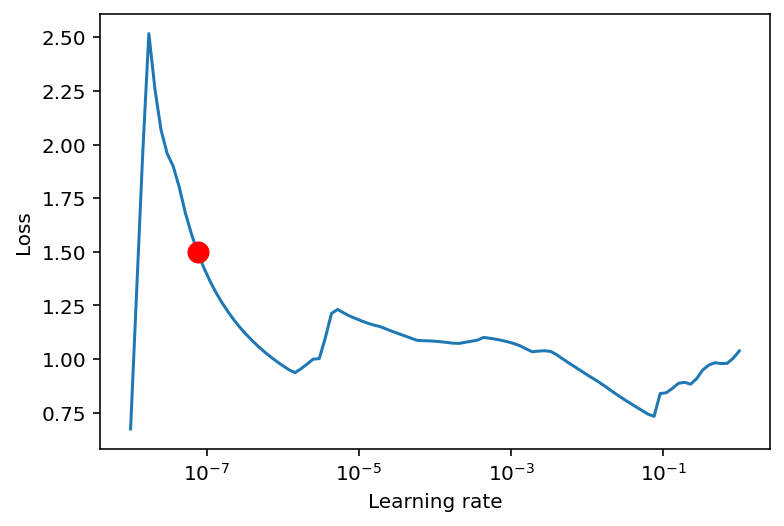

In [177]:
# fig = lr_finder.plot(suggest=True) # Plot
# fig.show()

In [109]:
# model.hparams.lr = lr_finder.suggestion()

In [187]:
trainer.fit(model, data_module)


  | Name      | Type      | Params
----------------------------------------
0 | model     | LSTMModel | 363 K 
1 | criterion | MSELoss   | 0     
----------------------------------------
363 K     Trainable params
0         Non-trainable params
363 K     Total params
1.454     Total estimated model params size (MB)
INFO:lightning:
  | Name      | Type      | Params
----------------------------------------
0 | model     | LSTMModel | 363 K 
1 | criterion | MSELoss   | 0     
----------------------------------------
363 K     Trainable params
0         Non-trainable params
363 K     Total params
1.454     Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Epoch 0, global step 6004: val_loss reached 0.20870 (best 0.20870), saving model to "/content/drive/MyDrive/Data_sci_Project/checkpoints/best-checkpoint-v13.ckpt" as top 1
INFO:lightning:Epoch 0, global step 6004: val_loss reached 0.20870 (best 0.20870), saving model to "/content/drive/MyDrive/Data_sci_Project/checkpoints/best-checkpoint-v13.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 1, global step 12009: val_loss reached 0.19626 (best 0.19626), saving model to "/content/drive/MyDrive/Data_sci_Project/checkpoints/best-checkpoint-v13.ckpt" as top 1
INFO:lightning:Epoch 1, global step 12009: val_loss reached 0.19626 (best 0.19626), saving model to "/content/drive/MyDrive/Data_sci_Project/checkpoints/best-checkpoint-v13.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 2, global step 18014: val_loss reached 0.18861 (best 0.18861), saving model to "/content/drive/MyDrive/Data_sci_Project/checkpoints/best-checkpoint-v13.ckpt" as top 1
INFO:lightning:Epoch 2, global step 18014: val_loss reached 0.18861 (best 0.18861), saving model to "/content/drive/MyDrive/Data_sci_Project/checkpoints/best-checkpoint-v13.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 3, global step 24019: val_loss reached 0.18424 (best 0.18424), saving model to "/content/drive/MyDrive/Data_sci_Project/checkpoints/best-checkpoint-v13.ckpt" as top 1
INFO:lightning:Epoch 3, global step 24019: val_loss reached 0.18424 (best 0.18424), saving model to "/content/drive/MyDrive/Data_sci_Project/checkpoints/best-checkpoint-v13.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 4, step 30024: val_loss was not in top 1
INFO:lightning:Epoch 4, step 30024: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 5, step 36029: val_loss was not in top 1
INFO:lightning:Epoch 5, step 36029: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 6, global step 42034: val_loss reached 0.17646 (best 0.17646), saving model to "/content/drive/MyDrive/Data_sci_Project/checkpoints/best-checkpoint-v13.ckpt" as top 1
INFO:lightning:Epoch 6, global step 42034: val_loss reached 0.17646 (best 0.17646), saving model to "/content/drive/MyDrive/Data_sci_Project/checkpoints/best-checkpoint-v13.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 7, global step 48039: val_loss reached 0.17626 (best 0.17626), saving model to "/content/drive/MyDrive/Data_sci_Project/checkpoints/best-checkpoint-v13.ckpt" as top 1
INFO:lightning:Epoch 7, global step 48039: val_loss reached 0.17626 (best 0.17626), saving model to "/content/drive/MyDrive/Data_sci_Project/checkpoints/best-checkpoint-v13.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 8, global step 54044: val_loss reached 0.17476 (best 0.17476), saving model to "/content/drive/MyDrive/Data_sci_Project/checkpoints/best-checkpoint-v13.ckpt" as top 1
INFO:lightning:Epoch 8, global step 54044: val_loss reached 0.17476 (best 0.17476), saving model to "/content/drive/MyDrive/Data_sci_Project/checkpoints/best-checkpoint-v13.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 9, step 60049: val_loss was not in top 1
INFO:lightning:Epoch 9, step 60049: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 10, step 66054: val_loss was not in top 1
INFO:lightning:Epoch 10, step 66054: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 11, step 72059: val_loss was not in top 1
INFO:lightning:Epoch 11, step 72059: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 12, global step 78064: val_loss reached 0.16834 (best 0.16834), saving model to "/content/drive/MyDrive/Data_sci_Project/checkpoints/best-checkpoint-v13.ckpt" as top 1
INFO:lightning:Epoch 12, global step 78064: val_loss reached 0.16834 (best 0.16834), saving model to "/content/drive/MyDrive/Data_sci_Project/checkpoints/best-checkpoint-v13.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 13, step 84069: val_loss was not in top 1
INFO:lightning:Epoch 13, step 84069: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 14, step 90074: val_loss was not in top 1
INFO:lightning:Epoch 14, step 90074: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 15, global step 96079: val_loss reached 0.16300 (best 0.16300), saving model to "/content/drive/MyDrive/Data_sci_Project/checkpoints/best-checkpoint-v13.ckpt" as top 1
INFO:lightning:Epoch 15, global step 96079: val_loss reached 0.16300 (best 0.16300), saving model to "/content/drive/MyDrive/Data_sci_Project/checkpoints/best-checkpoint-v13.ckpt" as top 1


Validating: 0it [00:00, ?it/s]

Epoch 16, step 102084: val_loss was not in top 1
INFO:lightning:Epoch 16, step 102084: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 17, step 108089: val_loss was not in top 1
INFO:lightning:Epoch 17, step 108089: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 18, step 114094: val_loss was not in top 1
INFO:lightning:Epoch 18, step 114094: val_loss was not in top 1


Validating: 0it [00:00, ?it/s]

Epoch 19, step 120099: val_loss was not in top 1
INFO:lightning:Epoch 19, step 120099: val_loss was not in top 1


1

In [188]:
trainer.test()

Testing: 0it [00:00, ?it/s]

--------------------------------------------------------------------------------
DATALOADER:0 TEST RESULTS
{'test_loss': 0.16300004720687866}
--------------------------------------------------------------------------------


[{'test_loss': 0.16300004720687866}]

In [189]:
train_model = SWaTPredictor.load_from_checkpoint(
    trainer.checkpoint_callback.best_model_path,
    n_features = n_features,learning_rate = learning_rate)

train_model.freeze()

Predict attack data

In [190]:
swat_attack.isnull().any()

Timestamp        False
FIT101           False
LIT101           False
MV101            False
P101             False
P102             False
AIT201           False
AIT202           False
AIT203           False
FIT201           False
MV201            False
P201             False
P202             False
P203             False
P204             False
P205             False
P206             False
DPIT301          False
FIT301           False
LIT301           False
MV301            False
MV302            False
MV303            False
MV304            False
P301             False
P302             False
AIT401           False
AIT402           False
FIT401           False
LIT401           False
P401             False
P402             False
P403             False
P404             False
UV401            False
AIT501           False
AIT502           False
AIT503           False
AIT504           False
FIT501           False
FIT502           False
FIT503           False
FIT504           False
P501       

In [191]:
x_attack = swat_attack.drop(columns=["Normal/Attack","Timestamp"])
y_attack= swat_attack["Normal/Attack"]

In [192]:
x_scale_attack = pd.DataFrame(
    scaler.transform(x_attack),
    index = x_attack.index,
    columns= x_attack.columns
)

In [193]:
y_attack = pd.DataFrame(
    le.transform(y_attack), #normal 1, attack 0
    index = y_attack.index,
    columns= ["label"]
)

In [194]:
attack_seq = sequences_convert(x_scale_attack,y_attack,sequence_length)

  0%|          | 0/449519 [00:00<?, ?it/s]

In [195]:
len(attack_seq)

449519

In [196]:
attack_dataset = DataLoader(SWaTDataset(attack_seq),batch_size=batch_size)

In [197]:
pred = []
labels = []
attacks = []

for item in tqdm(attack_dataset):
  sequences = item["sequences"]
  label = item["label"]
  # attack = item["attack"]
  # print(sequences.shape)

  _, output = train_model(sequences)
  # print(output)
  pred.append(output.numpy())
  labels.append(label.numpy())

  0%|          | 0/7024 [00:00<?, ?it/s]

In [198]:
print("pred, labels")
print(len(pred), len(labels))

pred, labels
7024 7024


In [199]:
f_pred = [elem for twod in pred for elem in twod]
f_labels = [elem for twod in labels for elem in twod]

In [200]:
f_pred = pd.DataFrame(f_pred, columns= x_attack.columns,
                      index= np.arange(attack_seq[0][1].name,attack_seq[-1][1].name+1))
f_labels = pd.DataFrame(f_labels, columns= x_attack.columns,
                        index= np.arange(attack_seq[0][1].name,attack_seq[-1][1].name+1))

In [201]:
f_pred.to_csv('/content/drive/MyDrive/Data_sci_Project/pred_3.csv')  
f_labels.to_csv('/content/drive/MyDrive/Data_sci_Project/label_3.csv')  